# 1

In [ ]:
import pandas as pd

# Cargar archivo CSV
file_path = "data/istio_request_2.2.csv"
df = pd.read_csv(file_path)

df['grpc_response_status'].fillna(0, inplace=True)

df['response_flags'] = df['response_flags'].astype(str).str.strip()  # Convertir a string y eliminar espacios

# Añade una columna 'resultado' con 'éxito' o 'error'.
df['result'] = df.apply(
    lambda row: 'success' if row['response_code'] == 200 and row['grpc_response_status'] == 0 and row['response_flags'] == '-' else 'error',
    axis=1
)

# Reorganiza los datos por "carga_origen", "carga_destino" y "fecha/hora".
df_sorted = df.sort_values(by=['source_workload', 'destination_workload', 'timestamp'])

# Guardar el archivo resultante
df_sorted.to_csv("aggregated_istio_data.csv", index=False)




In [ ]:
import pandas as pd

# Cargar archivo CSV
file_path = "aggregated_istio_data.csv"
df = pd.read_csv(file_path)

# Convertir timestamp a datetime para ordenar
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Clasificación antes de la separación
df.sort_values(by=['source_workload', 'destination_workload', 'timestamp'], inplace=True)

# Éxitos separados
df_success = df[df['result'] == 'success'].copy()

# Calcular new_request, new_istio_request_bytes y new_istio_request_duration_milliseconds con 0 para la primera líneadf_success['new_request'] = df_success.groupby(['source_workload', 'destination_workload'])['total_request'].diff().fillna(0)
df_success['new_istio_request_bytes'] = df_success.groupby(['source_workload', 'destination_workload'])['istio_request_bytes_sum'].diff().fillna(0)
df_success['new_istio_request_duration_milliseconds'] = df_success.groupby(['source_workload', 'destination_workload'])['istio_request_duration_milliseconds_sum'].diff().fillna(0)

# Aplicar condición si nueva_petición == 0
df_success.loc[df_success['new_request'] == 0, ['new_istio_request_bytes', 'new_istio_request_duration_milliseconds']] = 0

# Calcular latencia
df_success['latency'] = df_success['new_istio_request_duration_milliseconds'] / df_success['new_request']
df_success['latency'].fillna(0, inplace=True)

# Guardar los éxitos en un archivo
df_success.to_csv("success_istio_data.csv", index=False)

# Separación de errores HTTP y gRPC
df_http_errors = df[(df['result'] == 'error') & (df['request_protocol'] == 'http')].copy()
df_grpc_errors = df[(df['result'] == 'error') & (df['request_protocol'] == 'grpc')].copy()

error_files = []  #  Lista de archivos de error generados
# Gestión de errores HTTP
http_groups = df_http_errors.groupby(['request_protocol', 'response_code', 'grpc_response_status', 'response_flags'])

for (request_protocol, response_code, grpc_status, response_flags), df_error in http_groups:
    df_error = df_error.copy()
    
    # Calculer new_request, new_istio_request_bytes et new_istio_request_duration_milliseconds avec 0 pour la première ligne
    df_error['new_request'] = df_error.groupby(['source_workload', 'destination_workload'])['total_request'].diff().fillna(0)
    df_error['new_istio_request_bytes'] = df_error.groupby(['source_workload', 'destination_workload'])['istio_request_bytes_sum'].diff().fillna(0)
    df_error['new_istio_request_duration_milliseconds'] = df_error.groupby(['source_workload', 'destination_workload'])['istio_request_duration_milliseconds_sum'].diff().fillna(0)
    
    # Aplicar la condición si new_request == 0
    df_error.loc[df_error['new_request'] == 0, ['new_istio_request_bytes', 'new_istio_request_duration_milliseconds']] = 0
    
    # Calcular latencia
    df_error['latency'] = df_error['new_istio_request_duration_milliseconds'] / df_error['new_request']
    df_error['latency'].fillna(0, inplace=True)
    
    # Nombre el archivo según el error
    file_name = f"error_{request_protocol}_{response_code}_{response_flags}.csv"
    df_error.to_csv(file_name, index=False)
    error_files.append(df_error)

# Tratamiento de errores gRPC
grpc_groups = df_grpc_errors.groupby(['request_protocol', 'response_code', 'grpc_response_status', 'response_flags'])

for (request_protocol, response_code, grpc_status, response_flags), df_error in grpc_groups:
    df_error = df_error.copy()
    
    # Calcular new_request, new_istio_request_bytes y new_istio_request_duration_milliseconds con 0 para la primera línea
    df_error['new_request'] = df_error.groupby(['source_workload', 'destination_workload'])['total_request'].diff().fillna(0)
    df_error['new_istio_request_bytes'] = df_error.groupby(['source_workload', 'destination_workload'])['istio_request_bytes_sum'].diff().fillna(0)
    df_error['new_istio_request_duration_milliseconds'] = df_error.groupby(['source_workload', 'destination_workload'])['istio_request_duration_milliseconds_sum'].diff().fillna(0)
    
    # Aplicar la condición si new_request == 0
    df_error.loc[df_error['new_request'] == 0, ['new_istio_request_bytes', 'new_istio_request_duration_milliseconds']] = 0
    
    # Calcular latencia
    df_error['latency'] = df_error['new_istio_request_duration_milliseconds'] / df_error['new_request']
    df_error['latency'].fillna(0, inplace=True)
    
    # Nombre el archivo según el error
    file_name = f"error_{request_protocol}_{response_code}_{grpc_status}_{response_flags}.csv"
    df_error.to_csv(file_name, index=False)
    error_files.append(df_error)

# Fusionar los ficheros de exito y error
df_final = pd.concat([df_success] + error_files).sort_values(by=['source_workload', 'destination_workload', 'timestamp'])

# Guardar el archivo final
df_final.to_csv("new_request_istio_data.csv", index=False)

print("Traitement terminé. Fichier sauvegardé sous 'new_request_istio_data.csv'.")

In [ ]:
import pandas as pd 

# Cargar el archivo CSV
file_path = "new_request_istio_data.csv"
df = pd.read_csv(file_path)

# Convertir timestamp en datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Clasificación de datos
df.sort_values(by=['source_workload', 'destination_workload', 'timestamp'], inplace=True)

# Calcular porcentaje de aciertos, porcentaje de errores, recuento de aciertos, recuento de errores, duración de la solicitud correcta, duración de la solicitud errónea y latencia media par timestamp
grouped = df.groupby(['source_workload', 'destination_workload', 'timestamp'])
aggregated_rows = []

for (src, dst, ts), group in grouped:
    total_new_request = group['new_request'].sum()
    success_count = group[group['result'] == 'success']['new_request'].sum()
    error_count = total_new_request - success_count
    
    if total_new_request > 0:
        success_rate = success_count / total_new_request
        error_rate = 1 - success_rate
    else:
        success_rate = float('nan')
        error_rate = float('nan')
    
    # Calcular la duración de las solicitudes correctas y erróneas
    duration_success_request = group[group['result'] == 'success']['latency'].sum()
    duration_error_request = group[group['result'] == 'error']['latency'].sum()
    average_latency = duration_success_request + duration_error_request

    # Separar new_istio_request_bytes en éxito y error
    new_istio_request_bytes_success = group[group['result'] == 'success']['new_istio_request_bytes'].sum()
    new_istio_request_bytes_error = group[group['result'] == 'error']['new_istio_request_bytes'].sum()
    istio_request_bytes = new_istio_request_bytes_success+new_istio_request_bytes_error
    aggregated_rows.append([ts, src, dst, group['total_request'].max(), total_new_request, success_count, error_count, success_rate, error_rate, duration_success_request, duration_error_request, average_latency, new_istio_request_bytes_success, new_istio_request_bytes_error,istio_request_bytes])

# Creación de un DataFrame final
df_final = pd.DataFrame(aggregated_rows, columns=['timestamp', 'source_workload', 'destination_workload', 'total_request', 'new_request', 'success_count', 'error_count', 'success_rate', 'error_rate', 'duration_success_request', 'duration_error_request', 'average_latency', 'new_istio_request_bytes_success', 'new_istio_request_bytes_error','istio_request_bytes'])

# Guardar el archivo
output_file = "aggregated_istio_rates.csv"
df_final.to_csv(output_file, index=False)

print(f"Traitement terminé. Fichier sauvegardé sous {output_file}.")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargar archivo
file_path = "aggregated_istio_rates.csv"
df = pd.read_csv(file_path)

# Convertir fecha y hora en fecha y hora
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Definición de ventanas temporales
time_windows = ['15S', '30S', '1min', '5min', '10min']

# Inicializar un diccionario para almacenar los resultados
kpi_results = []

for window in time_windows:
    df_resampled = (df
        .groupby(['source_workload', 'destination_workload'])  
        .resample(window, on='timestamp', label='right', closed='right')  # Alinear con el final de la ventana
        .agg({
            'total_request': 'max',
            'new_request': 'sum',
            'success_count': 'sum',
            'error_count': 'sum',
            'success_rate': 'mean',
            'error_rate': 'mean',
            'average_latency': 'sum',
            'istio_request_bytes': 'sum'
        })
        .reset_index()
    )

    # Cálculo del rendimiento
    df_resampled['throughput'] = df_resampled['istio_request_bytes'] / pd.to_timedelta(window).total_seconds()
    
    # Cálculo del porcentaje de solicitudes
    df_resampled['request_rate'] = df_resampled['new_request'] / pd.to_timedelta(window).total_seconds()
    
    df_resampled['time_window'] = window
    kpi_results.append(df_resampled)

# Concatenar todos los resultados
df_final = pd.concat(kpi_results)

# Borra la línea donde timestamp == "2025-03-10 16:09:00".
starting_point = pd.Timestamp("2025-03-10 16:09:00")
df_final = df_final[df_final['timestamp'] != starting_point]

# Guardar como archivo CSV
df_final.to_csv("kiali_kpi_metrics.csv", index=False)


In [ ]:
import pandas as pd
import numpy as np

# Cargar archivo
df = pd.read_csv("kiali_kpi_metrics.csv")

# Convertir fecha y hora en fecha y hora
df['timestamp'] = pd.to_datetime(df['timestamp'])

## Convertir fecha y hora en fecha y hora

interval_mapping = {
    '15S': '1min',  # 15 secondes -> 1 minute
    '30S': '2min',  # 30 secondes -> 2 minutes
    '1min': '4min',  # 1 minute -> 4 minutes
    '5min': '10min',  # 5 minutes -> 10 minutes
    '10min': '10min'  # 10 minutes -> 10 minutes
}

latency_results = []

for window, interval in interval_mapping.items():
    df_filtered = df[df['time_window'] == window].copy()
    if df_filtered.empty:
        print(f"No data for time window: {window}")
        continue
    
    df_filtered.set_index('timestamp', inplace=True)
    
    try:
        df_grouped = (df_filtered.groupby(['source_workload', 'destination_workload'])
                      .resample(interval)
                      .agg({col: list for col in df.columns if col not in ['timestamp', 'source_workload', 'destination_workload', 'time_window']})
                      .reset_index())
    except Exception as e:
        print(f"Error during resampling for window {window}: {e}")
        continue
    
    for idx, row in df_grouped.iterrows():
        values = row.get('average_latency', [])
        frequencies = row.get('new_request', [])
        
        if not values or not frequencies or len(values) != len(frequencies):
            continue
        
        try:
            data = np.repeat(values, frequencies)
            if data.size == 0:
                continue
            
            percentiles = {
                'p50_latency': np.percentile(data, 50),
                'p90_latency': np.percentile(data, 90),
                'p95_latency': np.percentile(data, 95),
                'p99_latency': np.percentile(data, 99)
            }
        except Exception as e:
            print(f"Error calculating percentiles for row {idx} in window {window}: {e}")
            continue
        
        result = {**row.to_dict(), **percentiles, 'time_window': window}
        latency_results.append(result)

# Creación de un DataFrame final
df_latency = pd.DataFrame(latency_results)

# Guardar como archivo CSV
df_latency.to_csv("kiali_latency_percentiles.csv", index=False)

print("Traitement terminé. Fichier sauvegardé sous kiali_latency_percentiles.csv.")


In [ ]:
import pandas as pd

# 📂 Cargar el archivo CSV
file_path = "kiali_kpi_metrics.csv"
df = pd.read_csv(file_path)

# 🔄 Convertir la columna 'timestamp' a formato datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# 🏷️ Agregar una columna para el color del enlace basado en el success_rate
df['link_color'] = df['success_rate'].apply(lambda x: 'red' if x < 0.95 else 'green')

# 🏷️ Agregar una columna para la clase de anormalidad
df['Abnormality class'] = df['success_rate'].apply(lambda x: 'Anomalous' if x < 0.95 else 'Normal')

# 🔎 Verificar los primeros registros del DataFrame procesado
print(df.head())

# 📂 Guardar el DataFrame procesado
output_file = "kiali_kpi_metrics_processed.csv"
df.to_csv(output_file, index=False)
print(f"✅ Archivo procesado guardado como '{output_file}'")

C:\Users\marti\AppData\Local\Temp\ipykernel_49772\4279755777.py:61: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  start = df['timestamp'].min().floor('T')
C:\Users\marti\AppData\Local\Temp\ipykernel_49772\4279755777.py:62: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  end   = df['timestamp'].max().ceil('T')
C:\Users\marti\AppData\Local\Temp\ipykernel_49772\4279755777.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


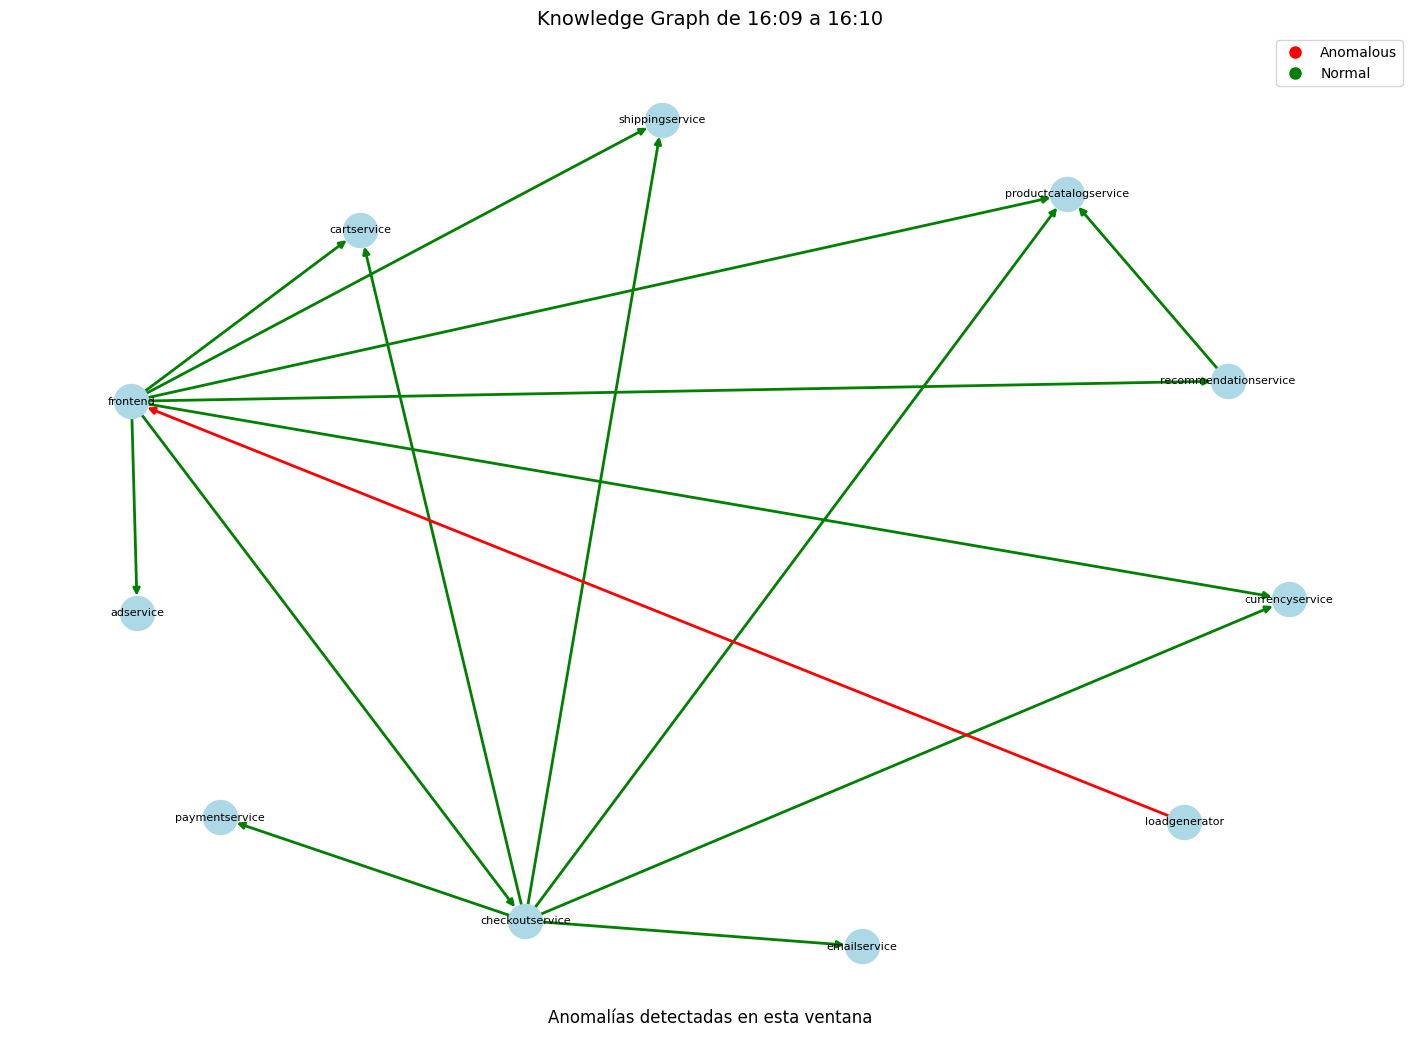

C:\Users\marti\AppData\Local\Temp\ipykernel_49772\4279755777.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


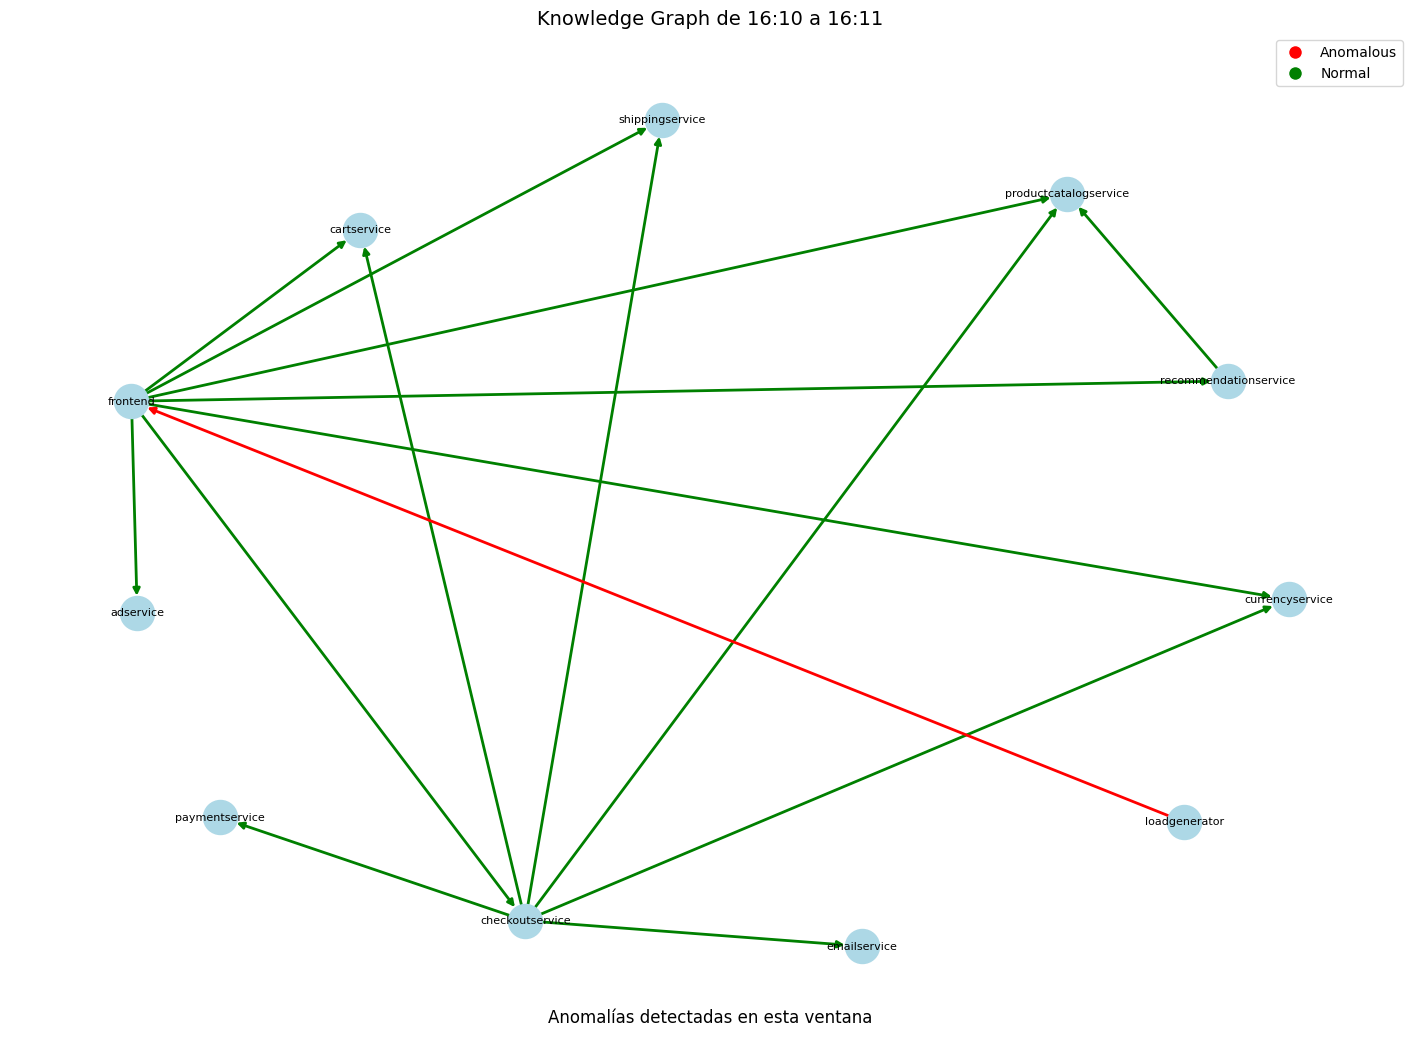

C:\Users\marti\AppData\Local\Temp\ipykernel_49772\4279755777.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


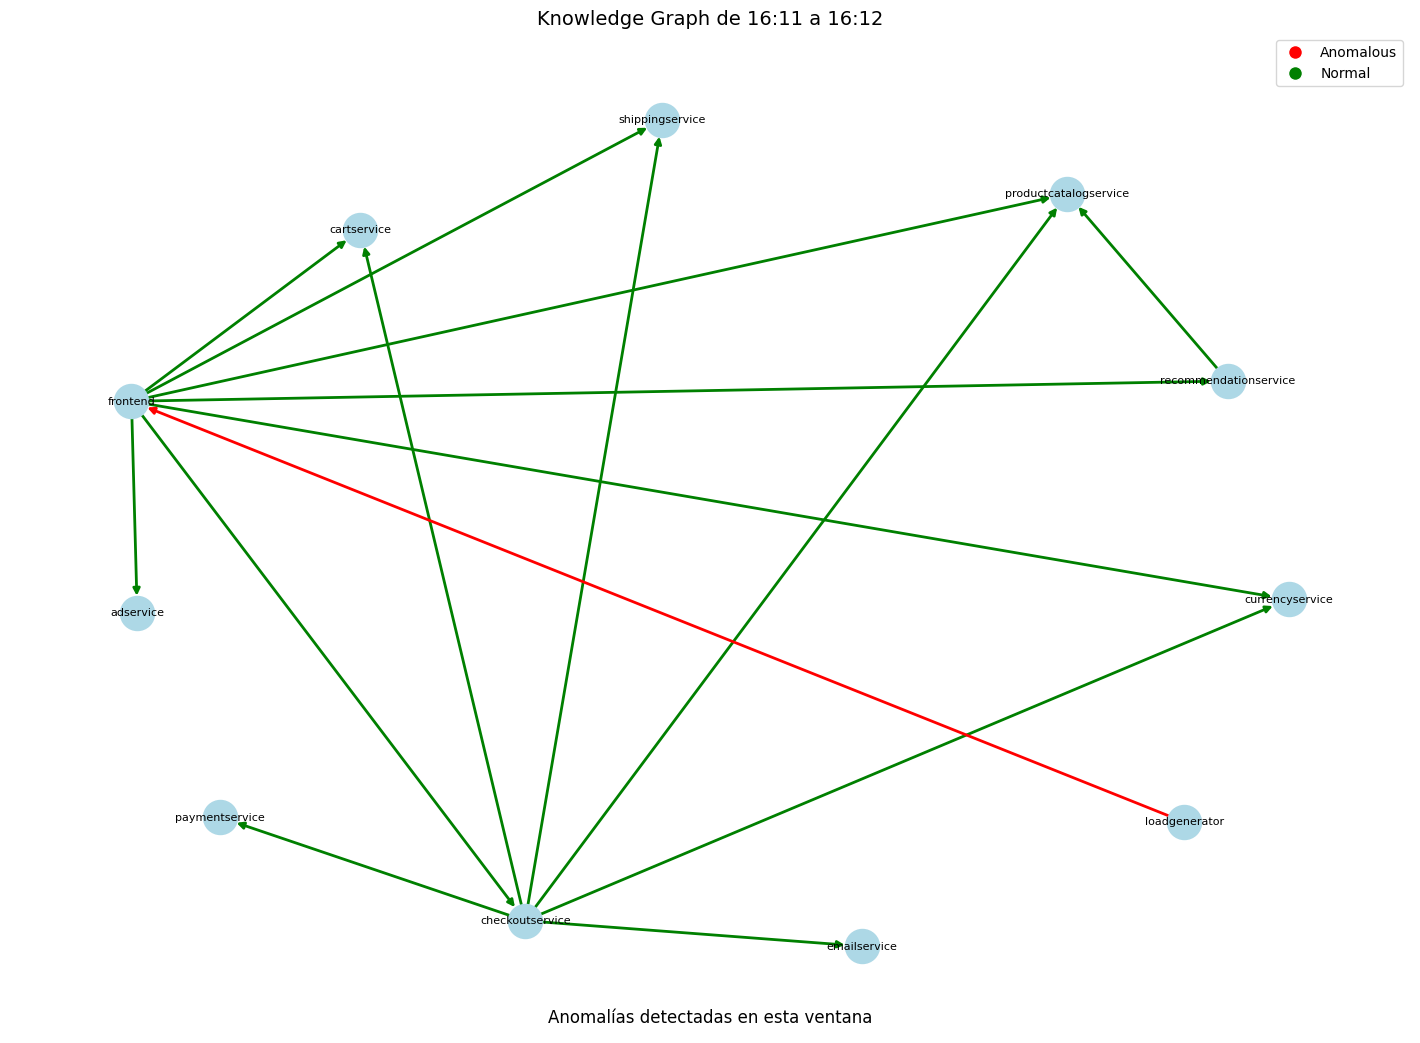

C:\Users\marti\AppData\Local\Temp\ipykernel_49772\4279755777.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


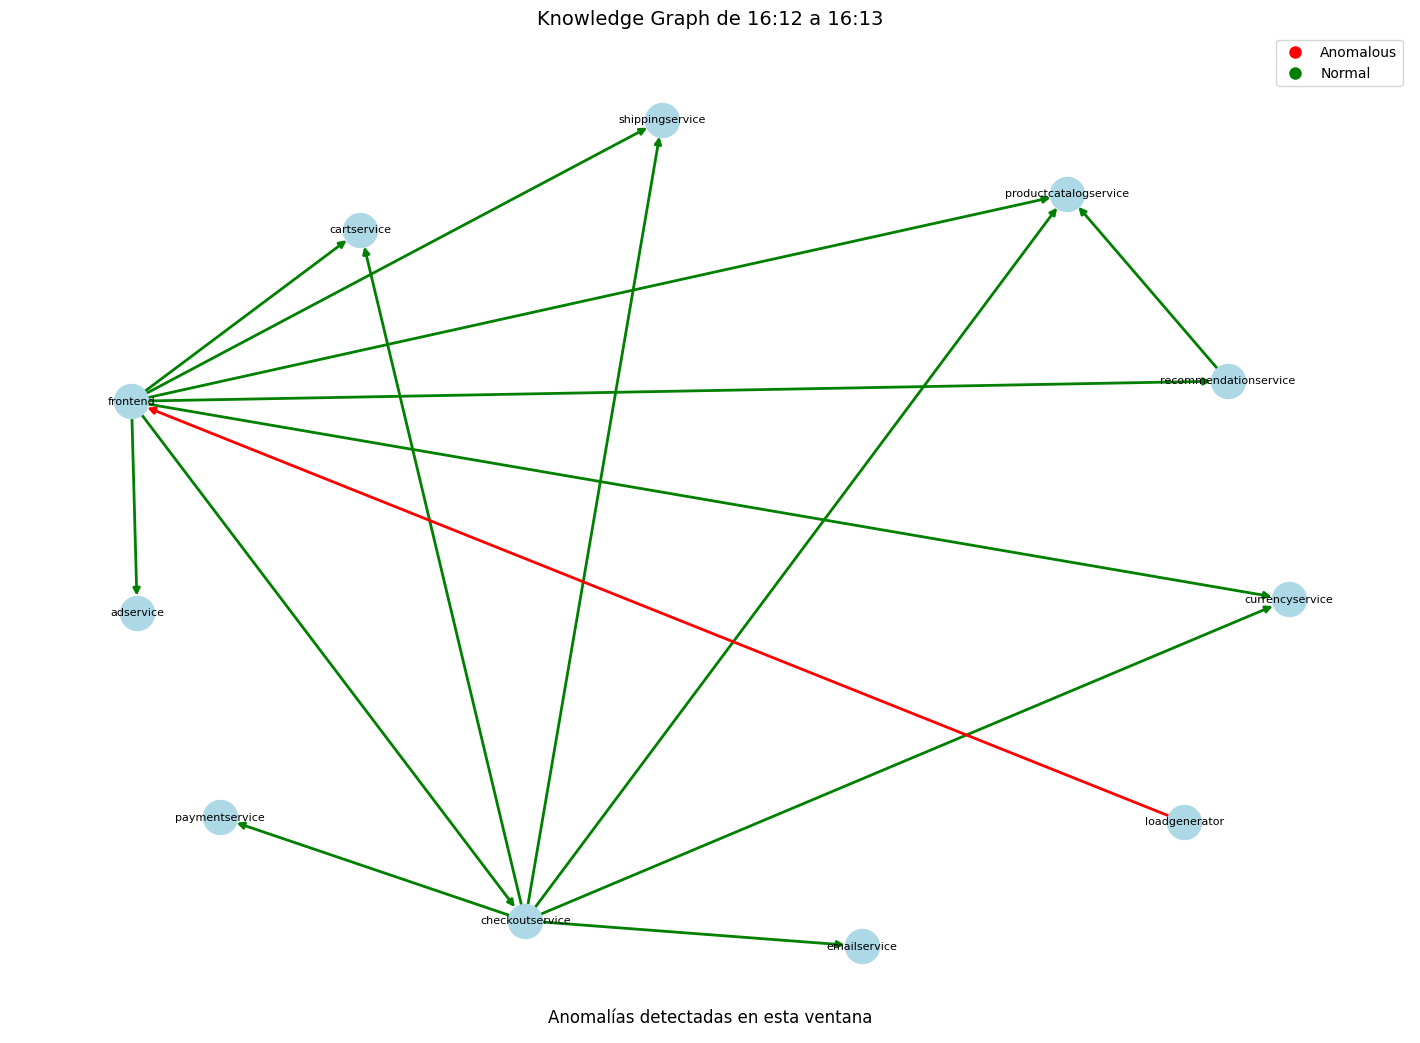

C:\Users\marti\AppData\Local\Temp\ipykernel_49772\4279755777.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


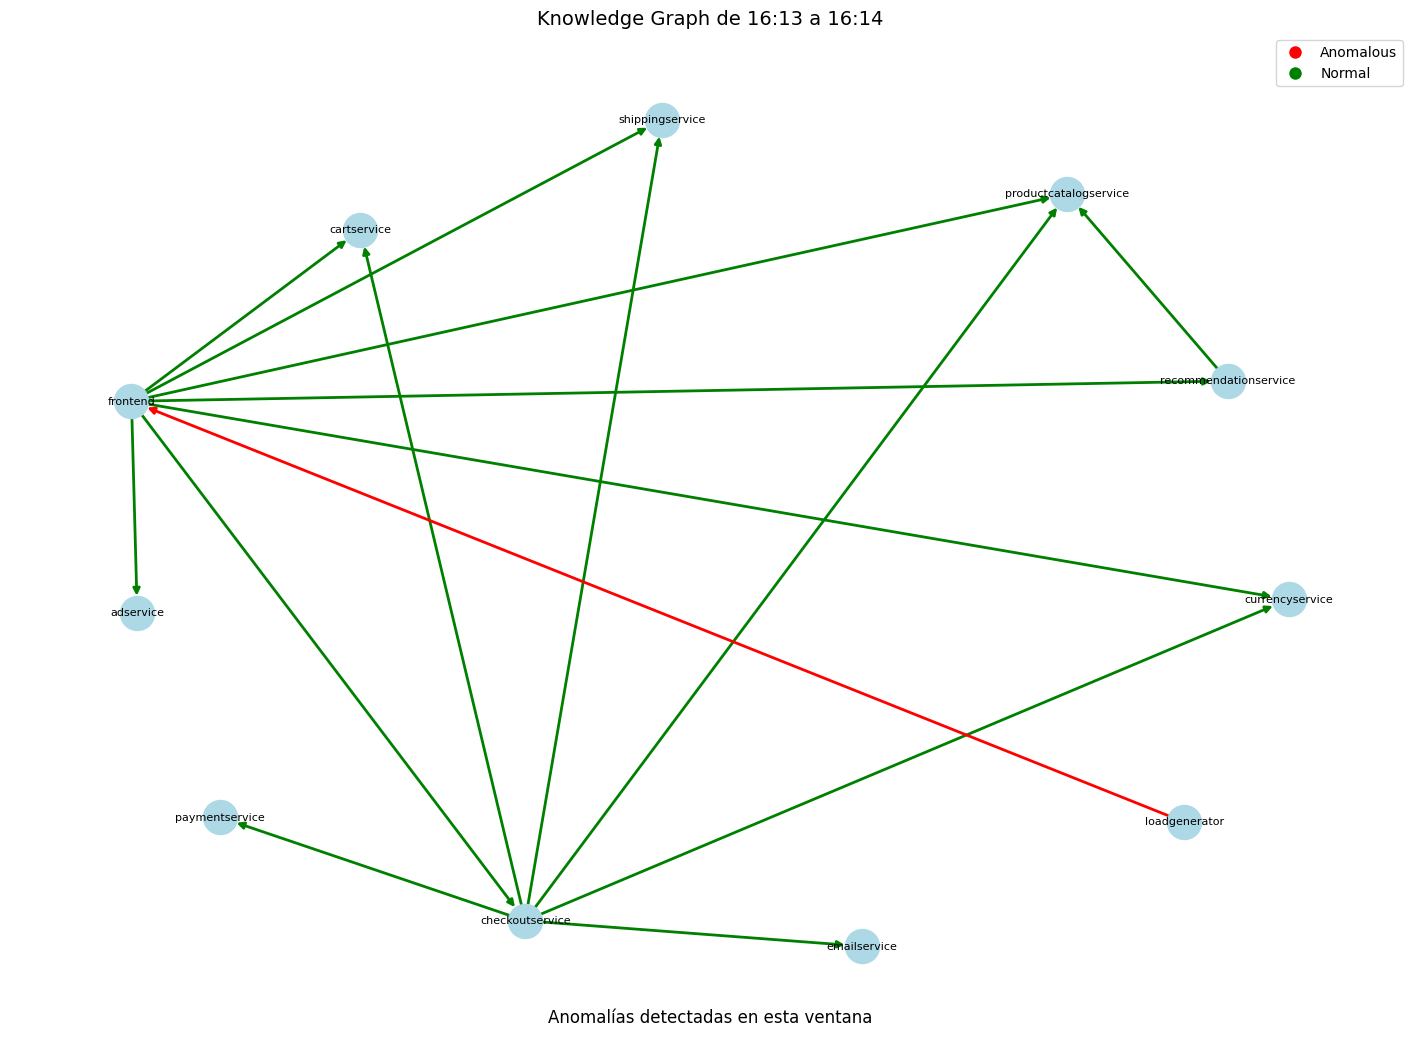

C:\Users\marti\AppData\Local\Temp\ipykernel_49772\4279755777.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


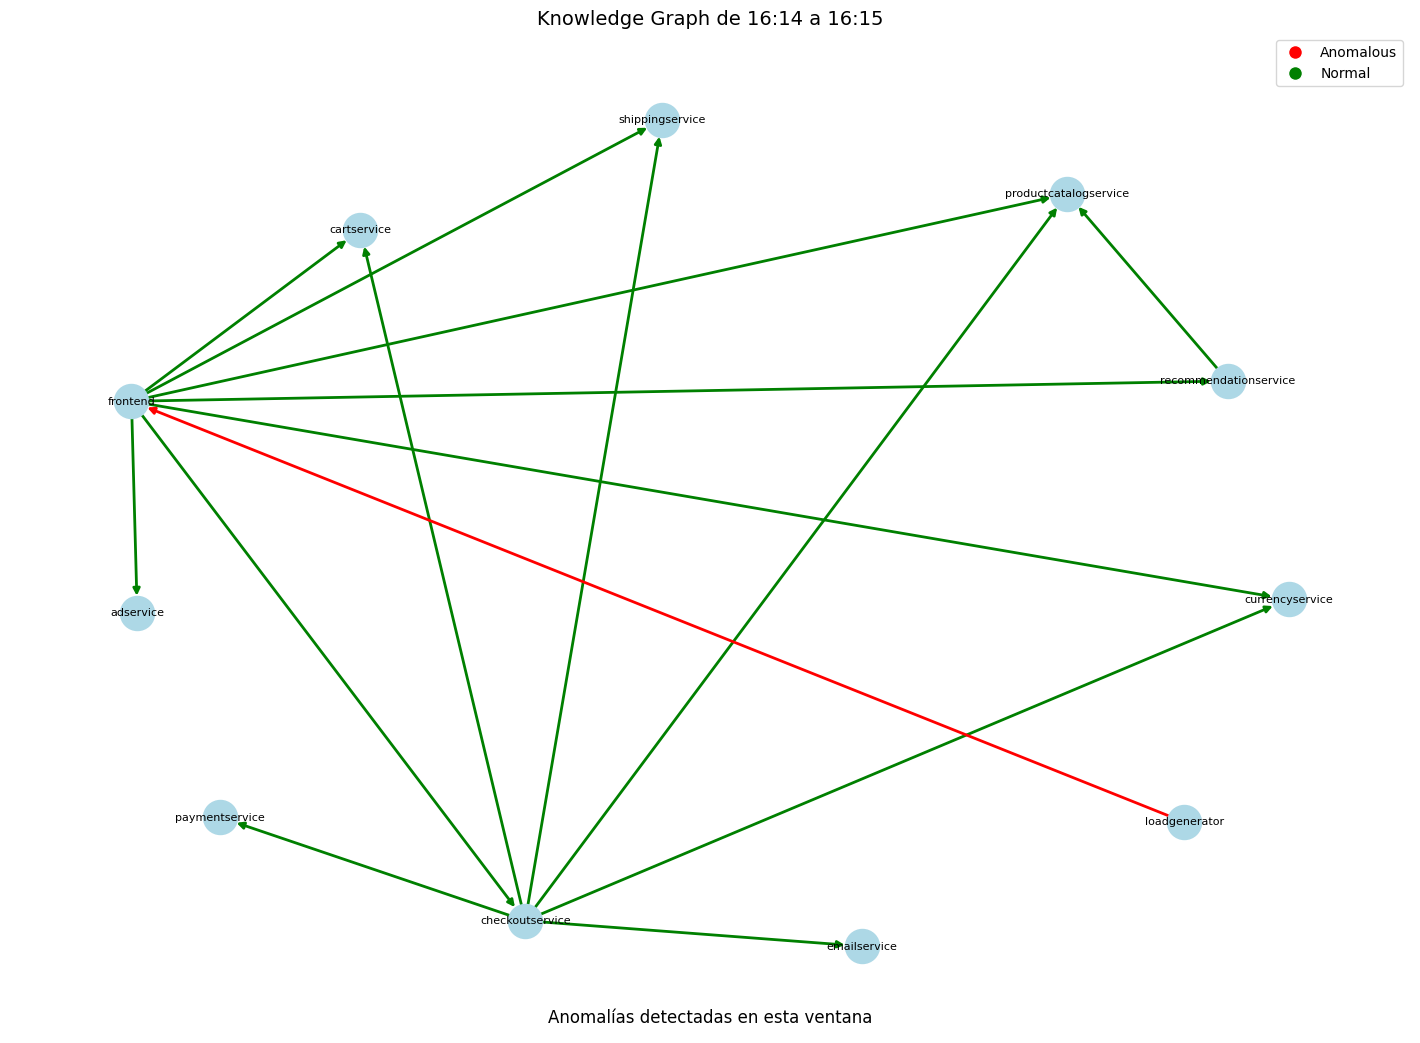

C:\Users\marti\AppData\Local\Temp\ipykernel_49772\4279755777.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


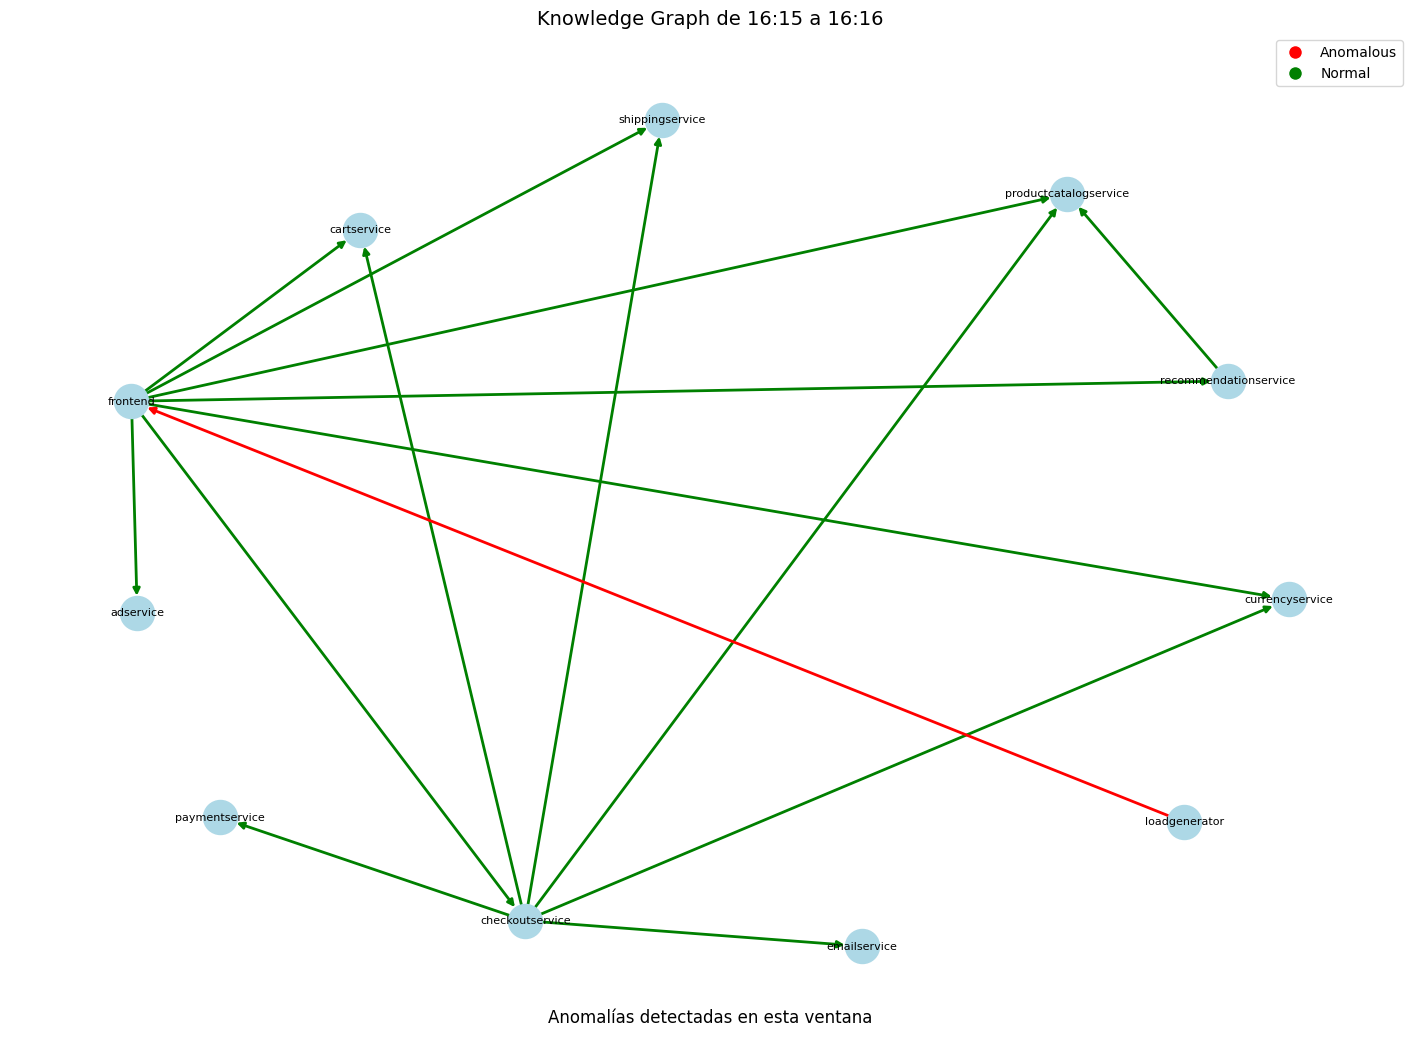

C:\Users\marti\AppData\Local\Temp\ipykernel_49772\4279755777.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


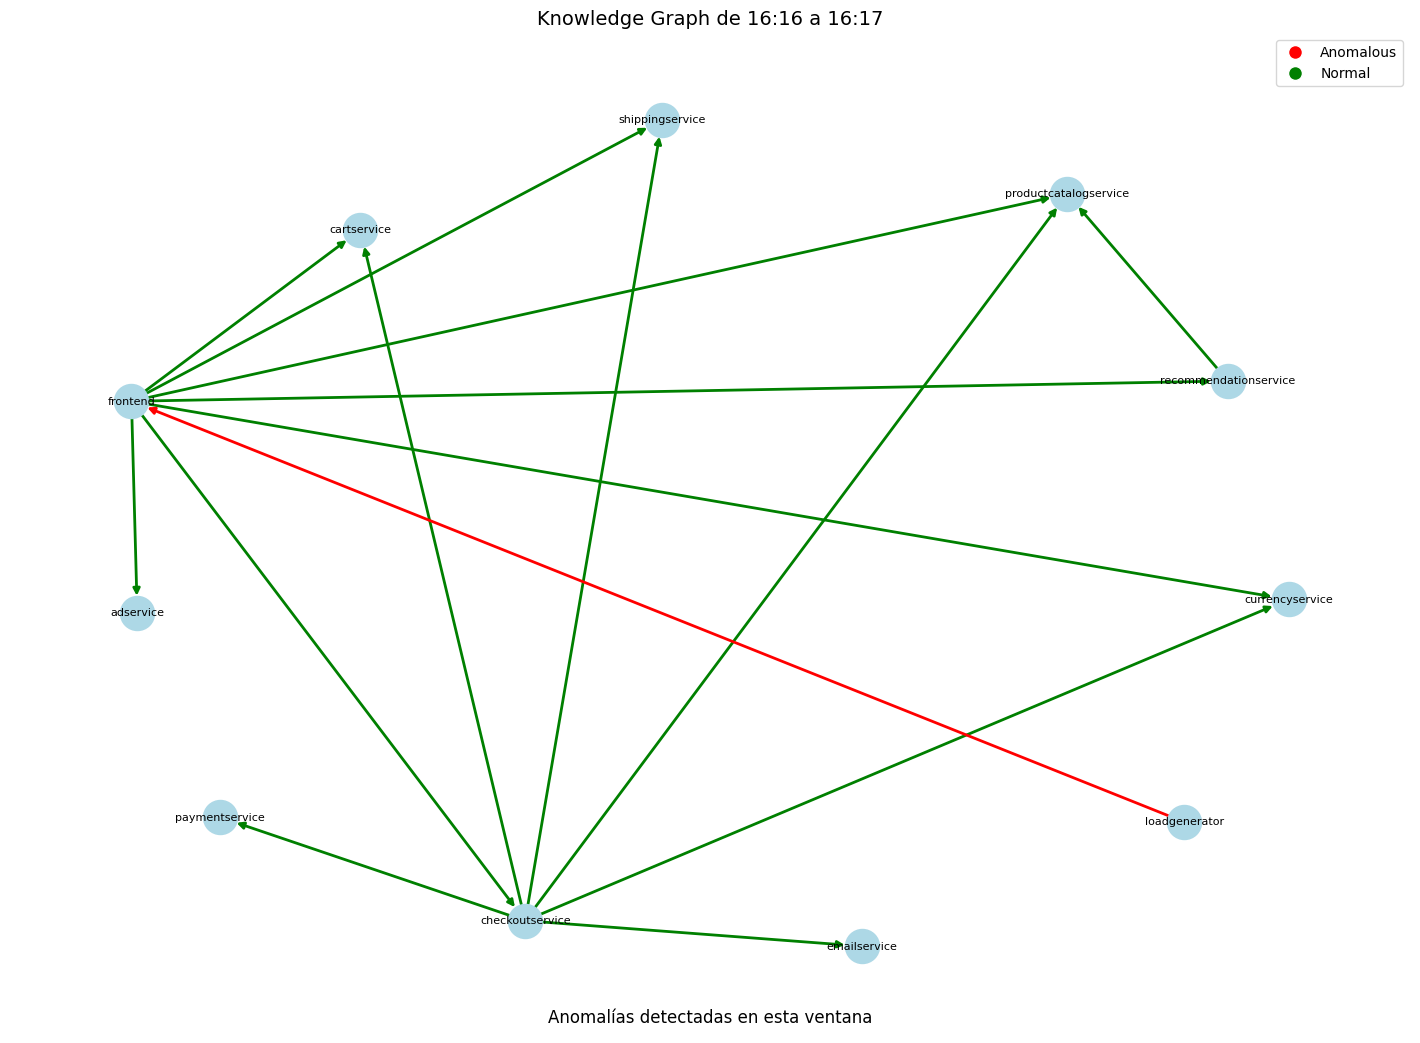

C:\Users\marti\AppData\Local\Temp\ipykernel_49772\4279755777.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


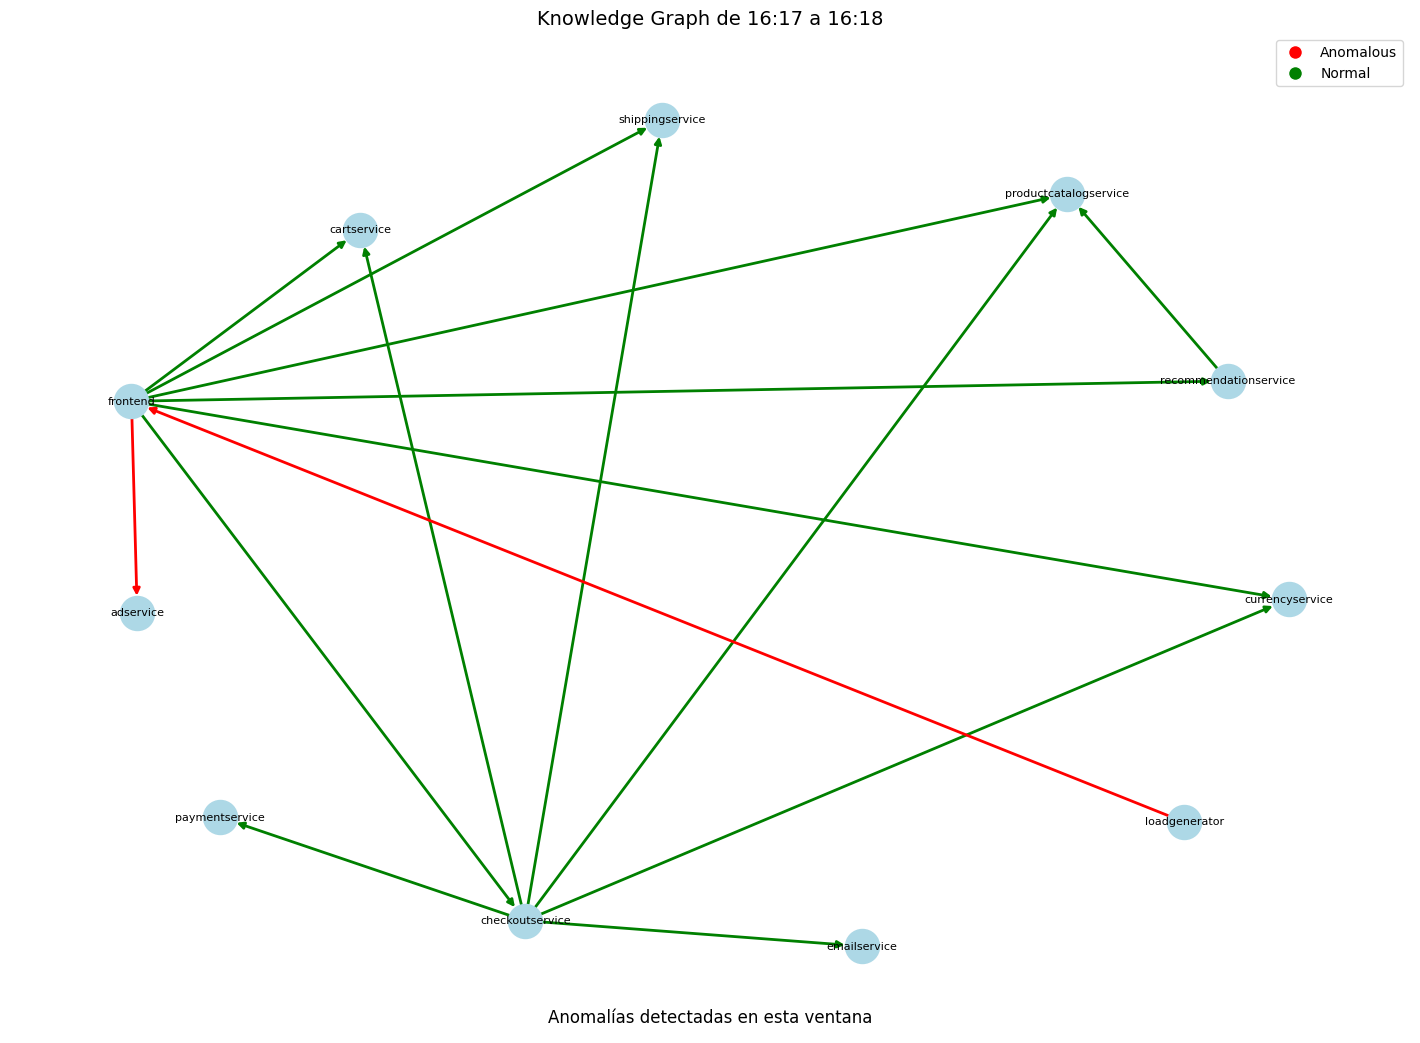

C:\Users\marti\AppData\Local\Temp\ipykernel_49772\4279755777.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


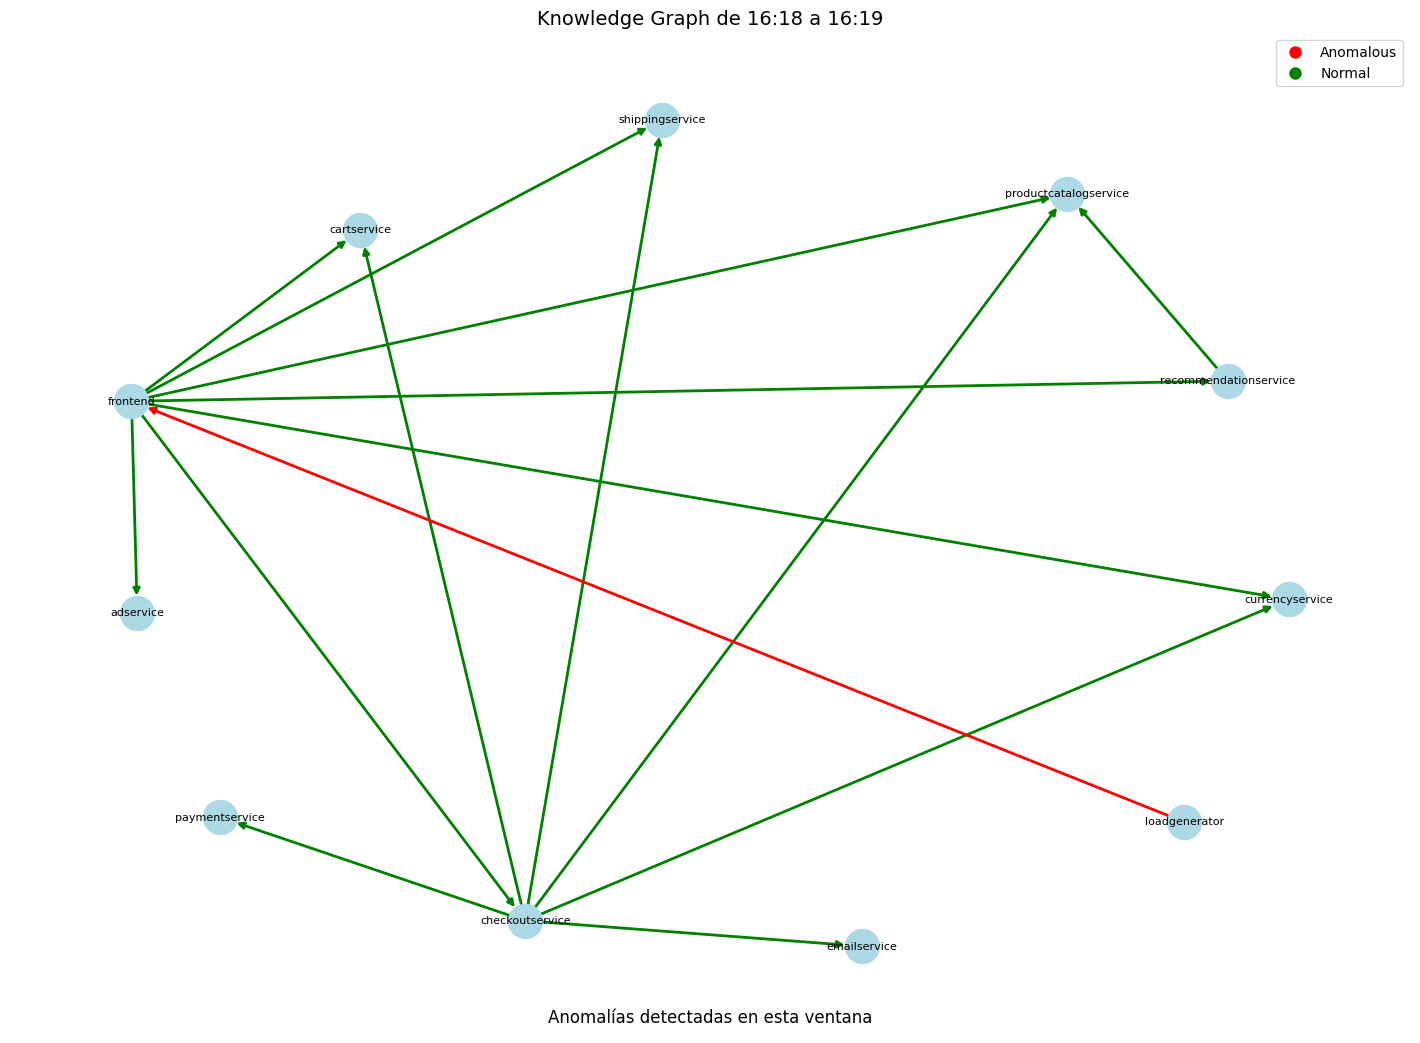

C:\Users\marti\AppData\Local\Temp\ipykernel_49772\4279755777.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


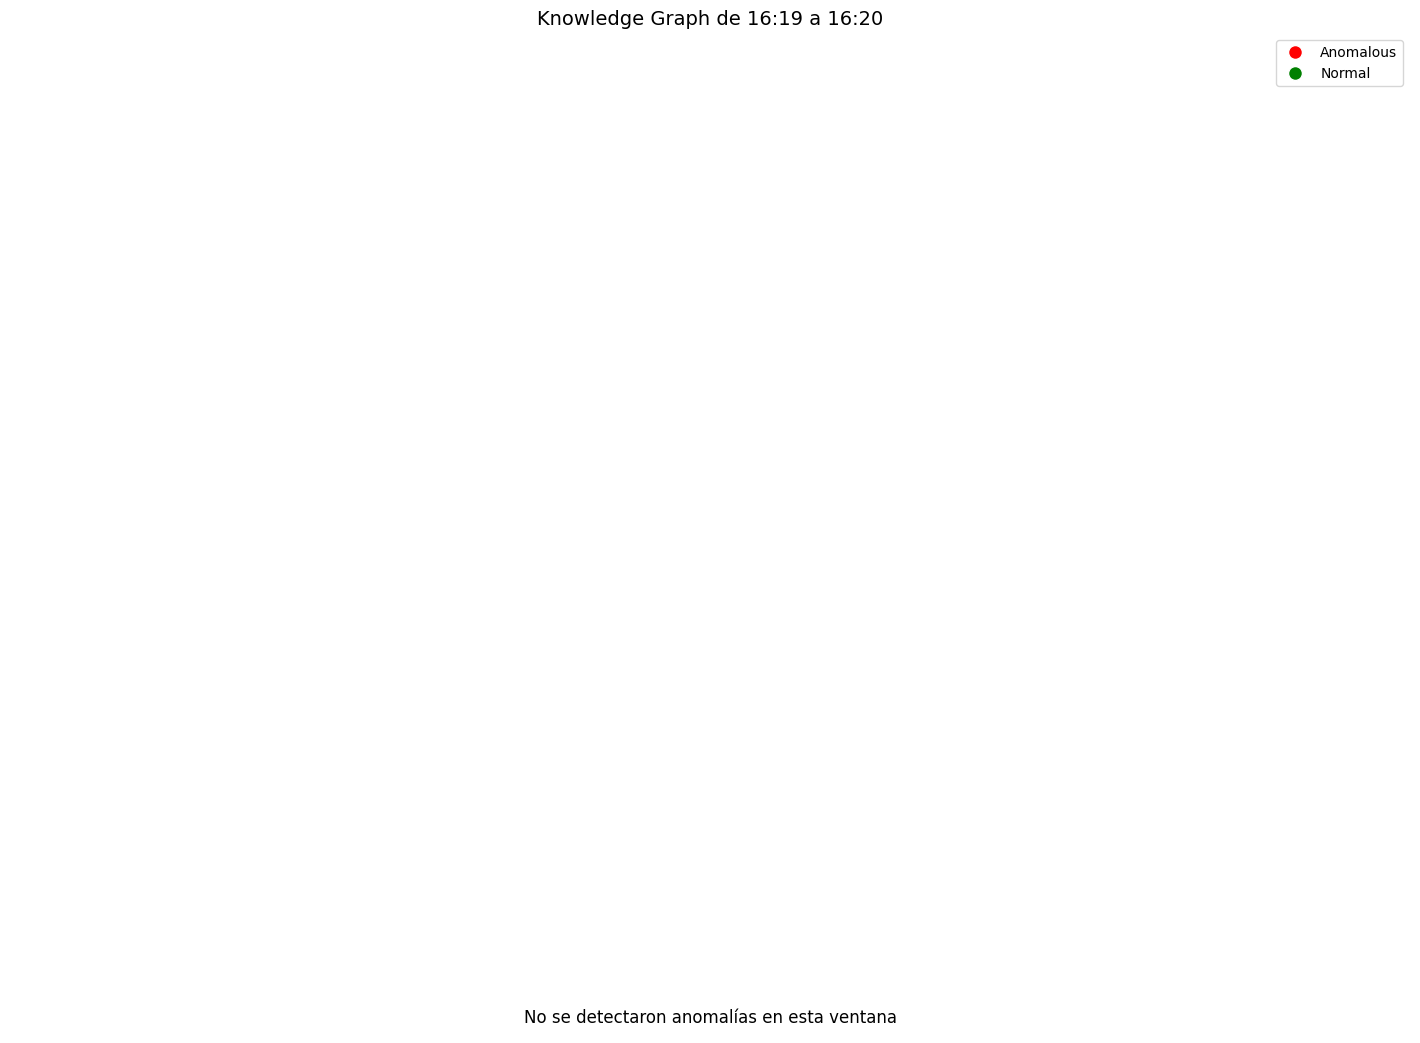

In [46]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import timedelta

# Carga el CSV y parsea timestamps
df = pd.read_csv('kiali_kpi_metrics_processed.csv', parse_dates=['timestamp'])

# Función para generar el grafo en un intervalo de 1 minuto
def create_knowledge_graph(df, start_time, end_time):
    filtered = df[(df['timestamp'] >= start_time) & (df['timestamp'] < end_time)]
    G = nx.DiGraph()
    anomaly_flag = False

    for _, row in filtered.iterrows():
        src = row['source_workload']
        dst = row['destination_workload']
        G.add_node(src, type='service')
        G.add_node(dst, type='service')
        color = row['link_color']
        anomaly = row['Abnormality class']
        if anomaly != 'Normal':
            anomaly_flag = True
        G.add_edge(src, dst, color=color, anomaly=anomaly)

    anomaly_class = 'Anomalous' if anomaly_flag else 'Normal'
    return G, anomaly_class

# Función para dibujar el grafo y la descripción
def plot_graph(G, start_time, end_time, anomaly_class):
    plt.figure(figsize=(14, 10))
    edge_colors = [d['color'] for _, _, d in G.edges(data=True)]
    pos = nx.spring_layout(G, seed=60, k=10)
    nx.draw(
        G, pos,
        with_labels=True,
        node_size=600,
        node_color='lightblue',
        edge_color=edge_colors,
        width=2,
        font_size=8
    )
    plt.title(f"Knowledge Graph de {start_time.strftime('%H:%M')} a {end_time.strftime('%H:%M')}", fontsize=14)

    # Leyenda
    red_patch   = plt.Line2D([0], [0], marker='o', color='w', label='Anomalous',   markerfacecolor='red',   markersize=10)
    green_patch = plt.Line2D([0], [0], marker='o', color='w', label='Normal',      markerfacecolor='green', markersize=10)
    plt.legend(handles=[red_patch, green_patch], loc='upper right')

    # Texto de anomalía
    if anomaly_class != 'Normal':
        plt.figtext(0.5, 0.01, "Anomalías detectadas en esta ventana", wrap=True, horizontalalignment='center', fontsize=12)
    else:
        plt.figtext(0.5, 0.01, "No se detectaron anomalías en esta ventana", wrap=True, horizontalalignment='center', fontsize=12)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Iterar ventanas de 1 minuto
start = df['timestamp'].min().floor('T')
end   = df['timestamp'].max().ceil('T')

current = start
while current < end:
    next_min = current + timedelta(minutes=1)
    G, anomaly_class = create_knowledge_graph(df, current, next_min)
    plot_graph(G, current, next_min, anomaly_class)
    current = next_min

In [1]:
import pandas as pd
from raphtory import Graph
import os
import shutil

# Cargar el dataset procesado
df = pd.read_csv("kiali_kpi_metrics_processed.csv", parse_dates=["timestamp"])

# Crear el grafo
g = Graph()

# Convertir timestamps a milisegundos desde época
df["ts_ms"] = df["timestamp"].astype("int64") // 10**6

# Añadir nodos con todas las propiedades disponibles
for _, row in df.iterrows():
    ts = int(row["ts_ms"])
    src = str(row["source_workload"])
    dst = str(row["destination_workload"])

    # Extraer todas las columnas salvo las de control
    properties = {
        col: row[col] for col in df.columns
        if col not in ["timestamp", "ts_ms", "source_workload", "destination_workload"]
    }

    g.add_node(timestamp=ts, id=src, properties=properties)
    g.add_node(timestamp=ts, id=dst, properties=properties)

    # Añadir arista con propiedades clave
    g.add_edge(
        timestamp=ts,
        src=src,
        dst=dst,
        properties={
            "success_rate": row.get("success_rate"),
            "request_rate": row.get("request_rate"),
            "throughput": row.get("throughput"),
            "link_color": row.get("link_color"),
            "abnormality_class": row.get("Abnormality class")
        }
    )

# Guardar el grafo
output_path = "graphs/kiali_fullnode_graph"
if os.path.exists(output_path):
    shutil.rmtree(output_path)
os.makedirs("graphs/", exist_ok=True)
g.save_to_file("graphs/kiali_fullnode_graph")

print("✅ Grafo guardado en:", output_path)


✅ Grafo guardado en: graphs/kiali_fullnode_graph


In [2]:
from raphtory.graphql import GraphServer
import time

# Inicializar el servidor desde la carpeta donde está guardado el grafo
server = GraphServer(work_dir="graphs/").start()
client = server.get_client()

# Pausa para asegurar que el grafo se cargue correctamente
time.sleep(2)

# Función segura para ejecutar queries
def safe_query(query, label):
    try:
        result = client.query(query)
        if "graph" in result or "__schema" in result:
            print(f"\n✅ {label} ejecutada con éxito.")
            return result
        else:
            print(f"\n⚠️ {label}: resultado inesperado.")
            return result
    except Exception as e:
        print(f"\n❌ Error en {label}: {e}")
        return None

# Query 1: Propiedades de los nodos
node_properties_query = """
{
  graph(path: "kiali_fullnode_graph") {
    nodes {
      list {
        name
        degree
        properties {
          keys
          values {
            value
          }
        }
      }
    }
  }
}
"""
node_data = safe_query(node_properties_query, "Node Properties")
if node_data and "graph" in node_data:
    nodes = node_data["graph"]["nodes"]["list"]
    for node in nodes:
        properties = dict(zip(node["properties"]["keys"], [v["value"] for v in node["properties"]["values"]]))
        print(f"Node: {node['name']}, Degree: {node['degree']}, Properties: {properties}")

# Query 2: Propiedades de las aristas
# Query para obtener las propiedades de las aristas
edge_properties_query = """
{
  graph(path: "kiali_fullnode_graph") {
    edges {
      list {
        src {
          name
        }
        dst {
          name
        }
        properties {
          keys
          values {
            value
          }
        }
      }
    }
  }
}
"""

# Ejecutar la query
edge_data = safe_query(edge_properties_query, "Edge Properties")

# Procesar y mostrar los resultados
if edge_data and "graph" in edge_data:
    edges = edge_data["graph"]["edges"]["list"]
    for edge in edges:
        src = edge["src"]["name"]
        dst = edge["dst"]["name"]
        properties = dict(zip(edge["properties"]["keys"], [v["value"] for v in edge["properties"]["values"]]))
        print(f"Edge: {src} -> {dst}, Properties: {properties}")
else:
    print("❌ No se pudieron obtener los datos de las aristas.")

# # Query 3: Nodos con alto grado
# high_degree_nodes_query = """
# {
#   graph(path: "communication_graph") {
#     nodes {
#       list {
#         name
#         degree
#       }
#     }
#   }
# }
# """
# node_degree_data = safe_query(high_degree_nodes_query, "Node Degrees")
# if node_degree_data and "graph" in node_degree_data:
#     high_degree_nodes = [
#         node for node in node_degree_data["graph"]["nodes"]["list"]
#         if node["degree"] > 5
#     ]
#     print("🎯 High Degree Nodes:")
#     for node in high_degree_nodes:
#         print(f"Node: {node['name']}, Degree: {node['degree']}")
test_query = """
{
  graph(path: "kiali_fullnode_graph") {
    edges {
      list {
        src {
          name
        }
        dst {
          name
        }
      }
    }
  }
}
"""
test_data = safe_query(test_query, "Test Query")
print(test_data)

# Query 4: Introspección del esquema
introspection_query = """
{
  __schema {
    types {
      name
      fields {
        name
        type {
          name
          kind
        }
      }
    }
  }
}
"""
schema_info = safe_query(introspection_query, "Schema Introspection")
if schema_info and "__schema" in schema_info:
    types = schema_info["__schema"]["types"]
    for type_info in types:
        print(f"Type: {type_info['name']}")
        if type_info["fields"]:
            for field in type_info["fields"]:
                print(f"  Field: {field['name']}, Type: {field['type']['name']}, Kind: {field['type']['kind']}")


✅ Node Properties ejecutada con éxito.
Node: checkoutservice, Degree: 7, Properties: {'error_count': 6.0, 'total_request': 146594.0, 'new_request': 583.0, 'average_latency': 6960.402866785636, 'request_rate': 0.9716666666666668, 'success_rate': 0.9909133900914696, 'throughput': 259.80833333333334, 'success_count': 577.0, 'time_window': '10min', 'istio_request_bytes': 155885.0, 'link_color': 'green', 'error_rate': 0.0090866099085305, 'Abnormality class': 'Normal'}
Node: cartservice, Degree: 2, Properties: {'error_count': 2.0, 'total_request': 3708665.0, 'new_request': 15225.0, 'average_latency': 671.6954642319669, 'request_rate': 25.375, 'success_rate': 0.999766791044776, 'throughput': 3686.1916666666666, 'success_count': 15223.0, 'time_window': '10min', 'istio_request_bytes': 2211715.0, 'link_color': 'green', 'error_rate': 0.0002332089552238, 'Abnormality class': 'Normal'}
Node: currencyservice, Degree: 2, Properties: {'error_count': 9.0, 'total_request': 12082237.0, 'new_request': 51

In [86]:
from raphtory import Graph
import pandas as pd
from datetime import datetime
import os
import shutil

# Cargar el CSV procesado
df = pd.read_csv("./kiali_kpi_metrics_processed.csv", parse_dates=["timestamp"])

# Crear el grafo
g = Graph()

# Añadir nodos y aristas al grafo con propiedades
for _, row in df.iterrows():
    ts = int(row["timestamp"].timestamp() * 1000)  # convertir a milisegundos
    src = row["source_workload"]
    dst = row["destination_workload"]
    
    g.add_node(timestamp=ts, id=src,properties={
        "type": "service",
        "total_request": float(row.get("total_request")),
        "new_request": float(row.get("new_request")),
        "success_count": float(row.get("success_count")),
        "error_count": float(row.get("error_count")),
        "success_rate": float(row.get("success_rate")),
        "error_rate": float(row.get("error_rate")),
        "istio_request_bytes": float(row.get("istio_request_bytes")),
        "throughput": float(row.get("throughput")),
        "request_rate": float(row.get("request_rate")),
        "time_window": row.get("time_window"),
        "Abnormality class": row.get("Abnormality class")
    })
    g.add_node(timestamp=ts, id=dst,properties={
        "type": "service",
        "total_request": float(row.get("total_request")),
        "new_request": float(row.get("new_request")),
        "success_count": float(row.get("success_count")),
        "error_count": float(row.get("error_count")),
        "success_rate": float(row.get("success_rate")),
        "error_rate": float(row.get("error_rate")),
        "istio_request_bytes": float(row.get("istio_request_bytes")),
        "throughput": float(row.get("throughput")),
        "request_rate": float(row.get("request_rate")),
        "time_window": row.get("time_window"),
        "Abnormality class": row.get("Abnormality class")
    })
    g.add_edge(
        timestamp=ts,
        src=src,
        dst=dst,
        properties={
            "success_rate": row["success_rate"],
            "link_color": row["link_color"],
            "abnormality_class": row["Abnormality class"],
            "request_rate": row["request_rate"],
            "throughput": row["throughput"]
        }
    )

# Verificar y guardar el grafo
output_dir = "graphs/microservice_anomaly_graph"
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)  # Eliminar el directorio si ya existe
os.makedirs("graphs/", exist_ok=True)
g.save_to_file(output_dir)
if os.path.exists(os.path.join(output_dir, "graph")):
    print(f"✅ Grafo guardado correctamente en: {output_dir}")
else:
    print(f"❌ Error al guardar el grafo en: {output_dir}")


✅ Grafo guardado correctamente en: graphs/microservice_anomaly_graph


In [87]:
from raphtory.graphql import GraphServer
import time

# 🔄 Asegurarse de que el grafo fue guardado en el directorio correcto
assert os.path.exists("graphs/microservice_anomaly_graph"), "❌ No se encontró el grafo en graphs/microservice_anomaly_graph"

# 🚀 Iniciar el servidor Raphtory
server = GraphServer(work_dir="graphs/").start()
client = server.get_client()

# ⏳ Esperar unos segundos para que el servidor cargue el grafo
time.sleep(2)

# ✅ Hacer una consulta de prueba
def safe_query(query, label):
    try:
        result = client.query(query)
        if "graph" in result or "__schema" in result:
            print(f"✅ {label} ejecutada con éxito:")
            return result
        else:
            print(f"⚠️ {label}: datos no válidos.")
            return result
    except Exception as e:
        print(f"❌ Error en {label}: {e}")
        return None

query = """
{
  graph(path: "microservice_anomaly_graph") {
    nodes {
      list {
        name
        degree
        properties {
          keys
          values { value }
        }
      }
    }
  }
}
"""
safe_query(query, "Consulta de nodos")


❌ Error en Consulta de nodos: After sending query to the server:
	{"query":"\n{\n  graph(path: \"microservice_anomaly_graph\") {\n    nodes {\n      list {\n        name\n        degree\n        properties {\n          keys\n          values { value }\n        }\n      }\n    }\n  }\n}\n","variables":{}}
Got the following errors:
	{"locations":[{"column":3,"line":3}],"message":"Graph not found microservice_anomaly_graph"}


In [ ]:
from raphtory.graphql import GraphServer

# 🧠 Iniciar el servidor y cliente Raphtory
server = GraphServer(work_dir="graphs/").start()
client = server.get_client()

# ✅ Verificar que el grafo fue guardado como "microservice_anomaly_graph"
graph_path = "microservice_anomaly_graph"

# 🔐 Función segura para ejecutar queries
def safe_query(query, label):
    try:
        result = client.query(query)
        if "graph" in result or "__schema" in result:
            print(f"✅ {label}:")
            return result
        else:
            print(f"⚠️ {label} ejecutada pero sin datos válidos.")
            return result
    except Exception as e:
        print(f"❌ Error en {label}: {e}")
        return None

# 🧪 Query de prueba de nodos
query_nodes = f"""
{{
  graph(path: "{graph_path}") {{
    nodes {{
      list {{
        name
        degree
        properties {{
          keys
          values {{ value }}
        }}
      }}
    }}
  }}
}}
"""
node_data = safe_query(query_nodes, "Consulta de nodos")


❌ Error en Consulta de nodos: After sending query to the server:
	{"query":"\n{\n  graph(path: \"microservice_anomaly_graph\") {\n    nodes {\n      list {\n        name\n        degree\n        properties {\n          keys\n          values { value }\n        }\n      }\n    }\n  }\n}\n","variables":{}}
Got the following errors:
	{"locations":[{"column":3,"line":3}],"message":"Graph not found microservice_anomaly_graph"}
